In [53]:
import os
import time
import numpy as np
import joblib
import pickle
import pandas as pd
import seaborn as sb
import truvari
import matplotlib.pyplot as plt
sb.set()
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score

def show_values_on_bars(axs, fmt='{:.2f}', buff=0, box=True, size=15):
    """ 
        Given a barchart (seaborn or matplotlib), add values on top of bars
         c/o https://stackoverflow.com/a/51535326 
    """
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + buff
            value = fmt.format(p.get_height())
            t = ax.text(_x, _y, value, ha="center", size=size)
            if box:
                t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

features = ['VARLEN', 'GT', 'GQ', 'DP', 'AD_r', 'AD_a', 'US_r', 'US_a', 
            'DS_r', 'DS_a', 'UC_r', 'UC_a', 'DC_r', 'DC_a', 'UDC_r', 
            'UDC_a', 'UCC_r', 'UCC_a', 'DDC_r', 'DDC_a', 'DCC_r', 'DCC_a', 
            'UMO_r', 'UMO_a', 'DMO_r', 'DMO_a', 'NR_r', 'NR_a', 'MO_r', 'MO_a', 
            'XC_r', 'XC_a', 'AC_r', 'AC_a', 'MC_r', 'MC_a', 'EC_r', 'EC_a', 
            'PL_ref', 'PL_het', 'PL_hom',
            'UXO_r', 'UXO_a', 'DXO_r', 'DXO_a', 'XO_r', 'XO_a']
trans_features = ["AD_r", "AD_a", "UC_r", "UC_a", "DC_a", "DC_r", 'UDC_r', 
                  'UDC_a', 'UCC_r', 'UCC_a', 'DDC_r', 'DDC_a', 'DCC_r', 
                  'DCC_a', 'XC_r', 'XC_a', 'AC_r', 'AC_a', 'MC_r', 'MC_a', 
                  'EC_r', 'EC_a']
keep_features = [_ for _ in features if _ not in trans_features] + ["RC"]
use_features = ['UCC', 'UC', 'EC', 'AD', 'DDC', 'DCC', 'AC', 'XC', 'UDC', 'DC', 'MC',
                'VARLEN', 'GT', 'GQ', 'DP', 'US_r', 'US_a', 'DS_r', 'DS_a', 'UMO_r',
                'UMO_a', 'DMO_r', 'DMO_a', 'NR_r', 'NR_a', 'MO_r', 'MO_a', 'PL_ref',
                'PL_het', 'PL_hom', 'UXO_r', 'UXO_a', 'DXO_r', 'DXO_a', 'XO_r', 'XO_a',
                'RC']
labels = ["GT_answer"]

def load_base(sample):
    """
    Use truvari to parse the intermerge vcf for a particular sample
    """
    base_vcf = "../data/paragraph_ref/sv_only.vcf.gz"
    return truvari.vcf_to_df(base_vcf, with_info=True, with_fmt=True, sample=sample)

# I want to see what happens when I transform the _r / _a numbers into all ratios of one another
def transform(data):
    data['VARLEN'] = data.apply(set_size, axis=1)
    ret = pd.DataFrame()
    union = set()
    others = []
    for i in trans_features:
        if i.endswith('_r') or i.endswith("_a"):
            union.add(i.split('_')[0])
        else:
            ret[i] = data[i]
    for i in sorted(list(union)):
        denom = data[i + '_a'].astype(int) + data[i + '_r']
        alt = data[i + '_a'] / denom
        ref = data[i + '_r'] / denom
        ret[i] = alt - ref
    
    for i in keep_features:
        ret[i] = data[i]
    # No coverage is assumed to be -1
    to_return = norm_rl(ret.fillna(-1))

    return to_return

def norm_rl(df):
    """
    Normalizes read length dependent features
    """
    rl_feat = ["US_r", "US_a", "DS_a", "DS_r", "UXO_r", "UXO_a", "DXO_r", "DXO_a", 
               "UMO_r", "UMO_a", "DMO_r", "DMO_a", "MO_r", "MO_a", "XO_r", "XO_a"]
    rl = df['MO_r'].max()
    df[rl_feat] = df[rl_feat] / rl
    return df

def set_size(x):
    # SET VARLEN to the appropriate sign
    return x["VARLEN"] if x["var_type"] == "INS" else -x["VARLEN"]

def norm_nr(line):
    if line["VARLEN"] < 0:
        line["NR_r"] = line["NR_r"] / abs(line["VARLEN"])
    else:
        line["NR_a"] = line["NR_a"] / line["VARLEN"]
    return line

def make_dataframe(base_variants, coverage_df, no_neigh=True):
    """
    Given a vcf, the base variants overwhich we're training, and the coverage df
    Build the full data-frame with their correct label
    If no_neigh, only return rows without neighbors
    returns dataframe
    """
    base = joblib.load(base_variants)
    cov_df = joblib.load(coverage_df)
    cov_df = cov_df.set_index("key")
    
    if no_neigh:
        cnt = len(base)
        base = base[base["NumNeighbors"] == 0]
        removed = cnt - len(base)
        rm_pct = removed / cnt * 100
        print(f"Removed {removed:,} of {cnt:,} ({rm_pct:.1f}%) sites with >= 1 Neighs. {len(base):,} Remaining.")
    data = cov_df.loc[cov_df.index.isin(base.index)]
    labels = base["GT"].apply(lambda x: truvari.get_gt(x).value)
    data = data.join(labels, rsuffix="_label")
    data = data.join(base["NumNeighbors"])
    return data

def make_paragraph_results(in_vcf):
    """
    Returns results and full from a join/anno of the base/comparison SV vcfs.jl
    """
    par_comp = truvari.vcf_to_df(in_vcf, True, True)
    chrY = par_comp.index.str.startswith("chrY")
    par_comp.loc[chrY, "PL_hom"] = par_comp.loc[chrY, "PL_het"]
    par_comp.loc[chrY, "PL_het"] = np.nan
    par_base = load_base(os.path.basename(in_vcf)[:-len(".vcf.gz")])
    par_full = par_base.join(par_comp, lsuffix="_base", rsuffix="_comp")
    par_full["GT_base"] = par_full["GT_base"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else np.nan).dropna().astype(int)
    par_full["GT_comp"] = par_full["GT_comp"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else np.nan).dropna().astype(int)
    par_full["concordant"] = par_full["GT_comp"] == par_full["GT_base"]
    pl_arr = par_full[['PL_ref', 'PL_het', 'PL_hom']].fillna(value=np.nan).values
    pl_arr.sort(axis=1)
    par_full["GQ"] = [(row[1] - row[0]) for row in pl_arr]
    par_test = par_full[["GQ", "GT_comp", "GT_base", "concordant", "DP", "svtype_base", "PL_ref", "PL_het", "PL_hom", "NumNeighbors"]]
    par_test.columns = ["GQ", "predict", "GT_label", "concordant", "DP", "svtype", "REF", "HET", "HOM", "NumNeighbors"]
    par_test = par_test.dropna()
    par_test["predict"] = par_test["predict"].astype(int)
    par_test["presence"] = par_test[["GT_label", "predict"]].apply(presence_compare, axis=1)
    par_test["predict_class"] = par_test[["GT_label", "predict"]].apply(concordance_compare, axis=1)
    return par_test, par_full

def make_flatvcf_results(base, comp):
    """
    Returns results and full from a join/anno of the base/comparison SV vcfs.jl
    """
    base = joblib.load(base)
    comp = joblib.load(comp)
    full = base.join(comp, lsuffix="_base", rsuffix="_comp")
    full["GT_base"] = full["GT_base"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else
np.nan).dropna().astype(int)
    full["GT_comp"] = full["GT_comp"].apply(lambda x: truvari.get_gt(x).value if isinstance(x, tuple) else
np.nan).dropna().astype(int)
    full["concordant"] = full["GT_comp"] == full["GT_base"]
    res = full[["GQ", "GT_comp", "GT_base", "concordant", "DP", "svtype_base", "PL_ref", "PL_het", "PL_hom",
"NumNeighbors"]]
    res.columns = ["GQ", "predict", "GT_label", "concordant", "DP", "svtype", "REF", "HET", "HOM", "NumNeighbors"]
    res = res.dropna()
    res["predict"] = res["predict"].astype(int)
    res["presence"] = res[["GT_label", "predict"]].apply(presence_compare, axis=1)
    return res, full

def rank_feature_importance(forest, features):
    """
    Given a created classifier pipeline (where step[1] is the RFC), and the feature names
    make a plot of the feature importance based on mean decrease in impurity
    """
    start_time = time.time()
    clsf = forest.steps[1][1]
    importances = clsf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clsf.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=features)
    forest_importances.sort_values(inplace=True, ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

def build_model(data, label):
    """
    Build and return fitted RFC
    """
    model = make_pipeline(StandardScaler(),
                        RandomForestClassifier(random_state=0,
                            n_jobs=-1,
                            bootstrap=True, 
                            max_features="sqrt",
                            max_depth=80,
                            min_samples_leaf = 4,
                            min_samples_split = 10,
                            n_estimators = 350)
                         )
    model = model.fit(data, label)
    return model

def run_model(model, data):
    t_data = transform(data)
    gts = pd.Series(model.predict(t_data), name="predict")
    #pls = pd.DataFrame(model.predict_proba(t_data), columns=["REF", "HET", "HOM"])
    pls = pd.DataFrame(model.predict_proba(t_data), columns=["HET", "HOM"])
    pls["REF"] = 99
    def rounder(d):
        r = -10 * np.log10(d)
        r = r.replace(-0, 0).replace([np.inf], 99).round().astype(int)
        return r
    pls['PL_ref'] = rounder(pls["REF"])
    pls['PL_het'] = rounder(pls['HET'])
    pls['PL_hom'] = rounder(pls['HOM'])
    pl_arr = pls[['PL_ref', 'PL_het', 'PL_hom']].values
    pl_arr.sort(axis=1)
    pls["GQ"] = [(row[1] - row[0]) for row in pl_arr]
    ret = pls.join(gts)
    ret.index = t_data.index
    #.apply(lambda x: truvari.GT(x).name))#test_base["GT"])
    return ret.join(data["GT_label"])

def make_roc_curves(results, title_label):
    """
    """
    for tys, label in [(["DEL", "INS"], "TOT"), (["INS"], "INS"), (["DEL"], "DEL")]:
        res = results[results["svtype"].isin(tys)]
        fpr, tpr, thresholds = roc_curve(res["concordant"], res["GQ"])
        auc = roc_auc_score(res["concordant"], res["GQ"])
        accuracy = res["concordant"].mean()
        plt.plot(fpr, tpr, label="%s (%.2f%%, %.2f)" % (label, accuracy * 100, auc))
    plt.title(f"{title_label} ROC curves")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(title="SV (ACC, AUC)")
    hide = plt.show()

def summarize_perf_by_attribs(results):
    rows = []
    for vals, dat in results.groupby(["svtype", "GT_label"]):
        dat = dat.groupby(["concordant"]).count()
        tp = dat.loc[True]["REF"]
        fp = dat.loc[False]["REF"]
        rows.append([vals[0], truvari.GT(vals[1]).name, tp / (tp + fp)])
    summary = pd.DataFrame(rows, columns=["svtype", "GT", "pct_correct"])

    p = sb.barplot(data=summary, x="GT", y="pct_correct", hue="svtype")
    p.set(title="Performance by Type/GT", ylim=(0,1.1), xlabel="Label GT")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    show_values_on_bars(p, box=False)
    plt.show()
    return summary

def make_gt_heatmap(results):
    rows = np.zeros((3,3))
    for label, dat in results.groupby(["GT_label", "predict"]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        if label[0] >= 3 or label[1] >= 3:
            continue
        cnt = len(dat)
        rows[label[0]][label[1]] = cnt
    rows = pd.DataFrame(rows, index=["REF", "HET", "HOM"], columns=["REF", "HET", "HOM"])
    pred_rows = rows / rows.sum(axis=0)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()
    label_rows = rows.T / rows.sum(axis=1)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()
    
def presence_compare(vals):
    base, comp = vals.to_list()
    if base == 0:
        if comp == 0:
            return "TN"
        else:
            return "FP"
    else:
        if comp == 0:
            return "FN"
        else:
            return "TP"

def concordance_compare(vals):
    base, comp = vals.to_list()
    if base == 0:
        if comp == 0:
            return "TN"
        else:
            return "FP"
    elif base == 1:
        if comp == 0:
            return "FN"
        if comp == 1:
            return "TP"
        else:
            return "FP"
    elif base == 2:
        if comp == 0:
            return "FN"
        if comp == 1:
            return "FP"
        else:
            return "TP"

def performance_table(m_data, key="presence"):
    counts = m_data[key].value_counts()
    tp = counts["TP"] if "TP" in counts else 0
    fp = counts["FP"] if "FP" in counts else 0
    tn = counts["TN"] if "TN" in counts else 0
    fn = counts["FN"] if "FN" in counts else 0
    try:
        tpr = tp / (tp + fn)
    except Exception:
        tpr = None
    try:
        tnr = tn / (tn + fp)
    except Exception:
        tnr = None
    try:
        ppv = tp / (tp + fp)
    except Exception:
        ppv = None
    try:
        npv = tn / (tn + fn)
    except Exception:
        npv = None
    try:
        fpr = fp / (fp + tn)
    except Exception:
        fpr = None
    try:
        acc = (tp + tn) / counts.sum()
    except Exception:
        acc = None
    try:
        fdr = fp / (fp + tp)
    except Exception:
        fdr = None
    f1 = 2 * ((ppv * tpr) / (ppv + tpr))
    ba = (tpr + tnr) / 2
    return pd.DataFrame([{"TPR": tpr, "FPR": fpr, "FDR": fdr, 
                          "ACC": acc, "TNR": tnr, "PPV": ppv, 
                          "NPV": npv, "F1": f1, "BA":ba}])

def predict_gt(m_data, model):
    # Predict the GT for the test data and fill in extra annotation
    results = run_model(model, m_data)
    results["concordant"] = results["predict"] == results["GT_label"]
    results["presence"] = results[["GT_label", "predict"]].apply(presence_compare, axis=1)
    results["predict_class"] = results[["GT_label", "predict"]].apply(concordance_compare, axis=1)
    svtype = m_data["var_type"]
    svtype.name = "svtype"
    results = results.join(svtype)
    results = results.join(m_data["DP"])
    results = results.join(m_data["NumNeighbors"])
    return results

def accuracy_report(results):
    print(len(results), "SVs to report")
    print("Overall Accuracy:", results["concordant"].mean())
    print(results.groupby(["GT_label"])["concordant"].mean())

    make_roc_curves(results, "Overall")
    make_roc_curves(results[results["GT_label"] != 0], "Present SVs")
    make_roc_curves(results[results["GT_label"] == 0], "Reference SVs")

    summary = summarize_perf_by_attribs(results)
    print(summary)

    make_gt_heatmap(results)
    print("Presence Performance Overall")
    print(performance_table(results))

# Train Model

In [49]:
train_data = joblib.load("train_data.jl")

In [3]:
print("Training Label Freq")
train_data["GT_label"].apply(truvari.GT).value_counts()

Training Label Freq


GT.REF    23035
GT.HET    20987
GT.HOM    13689
Name: GT_label, dtype: int64

In [4]:
suf_cov = (train_data["DP"] >= 10) & (train_data["DP"] <= 100)
train_data[suf_cov]["GT_label"].apply(truvari.GT).value_counts()

GT.REF    19389
GT.HET    18399
GT.HOM    11835
Name: GT_label, dtype: int64

In [5]:
sub = train_data[suf_cov].sample(frac=.75, random_state=192)
sub["GT_label"].apply(truvari.GT).value_counts()

GT.REF    14520
GT.HET    13799
GT.HOM     8898
Name: GT_label, dtype: int64

In [51]:
pres_predict = train_data["GT_label"] != 0
model = build_model(transform(train_data[pres_predict]), train_data[pres_predict]["GT_label"])
#joblib.dump(model, "GTModel_Aug421.jl")

/raid/home/english/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
model = joblib.load("GTModel_Aug421.jl")

Elapsed time to compute the importances: 0.302 seconds


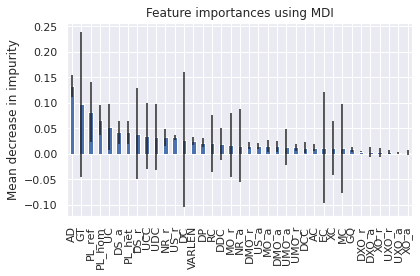

In [7]:
rank_feature_importance(model, transform(train_data).columns)

Elapsed time to compute the importances: 0.322 seconds


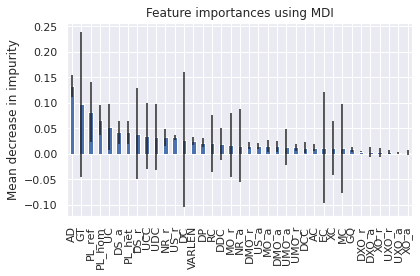

In [8]:
rank_feature_importance(model, transform(train_data).columns)

# Test Model

In [27]:
test_data = joblib.load("test_data.jl")

In [54]:
results = predict_gt(test_data, model)
a = performance_table(results)
a["Method"] = "BioGraph"
a["Neigh"] = True
b = performance_table(results[results["NumNeighbors"] == 0])
b["Method"] = "BioGraph"
b["Neigh"] = False
bg_presence = pd.concat([a,b])
bg_presence

/raid/home/english/pyenv/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA,Method,Neigh
0,1.0,1.0,0.846758,0.153242,0.0,0.153242,None,0.265758,0.5,BioGraph,True
0,1.0,1.0,0.767886,0.232114,0.0,0.232114,None,0.376773,0.5,BioGraph,False


In [ ]:
old_model = joblib.load("/home/releases/biograph_model-7.0.0.ml")

In [42]:
def run_gt(classifier, m_data, features=None, thresh=0.50):
    """
    Run gt classification - drops then replaces "GT" column
    """
    data = m_data.drop(["GT"], axis=1)
    to_classify = data.dropna(subset=features)
    gt_prob = classifier.predict_proba(to_classify[features])
    gt_pred = pd.Series([1 if i > thresh else 2 for i in gt_prob[:, 1]],
                        name="predict", index=to_classify.index)
    results = pd.concat([m_data, gt_pred], axis=1)
    results["concordant"] = results["predict"] == results["GT_label"]
    results["presence"] = results[["GT_label", "predict"]].apply(presence_compare, axis=1)
    results["predict_class"] = results[["GT_label", "predict"]].apply(concordance_compare, axis=1)
    #svtype = m_data["var_type"]
    #svtype.name = "svtype"
    #results = results.join(svtype)
    #results = results.join(m_data["DP"])
    #results = results.join(m_data["NumNeighbors"])
    return results

old_results = run_gt(old_model["model_gt"], test_data, old_model["features_gt"])

In [55]:
keep = old_results["GT_label"] != 0
print((old_results[keep]["GT_label"] == old_results[keep]["predict"]).mean())
print((results[keep]["GT_label"] == results[keep]["predict"]).mean())

0.7858752478817379
0.8634847665404723


In [11]:
#model = joblib.load("GTModel_Aug221.jl")
results = predict_gt(test_data, model)

/raid/home/english/pyenv/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
a = performance_table(results)
a["Method"] = "BioGraph"
a["Neigh"] = True
b = performance_table(results[results["NumNeighbors"] == 0])
b["Method"] = "BioGraph"
b["Neigh"] = False
bg_presence = pd.concat([a,b])
bg_presence

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA,Method,Neigh
0,0.656301,0.079280,0.400297,0.880200,0.920720,0.599703,0.936718,0.626727,0.788510,BioGraph,True
0,0.901376,0.038285,0.123203,0.947709,0.961715,0.876797,0.969934,0.888917,0.931545,BioGraph,False


144791 SVs to report
Overall Accuracy: 0.8665386660773114
GT_label
0    0.920720
1    0.539534
2    0.664625
Name: concordant, dtype: float64


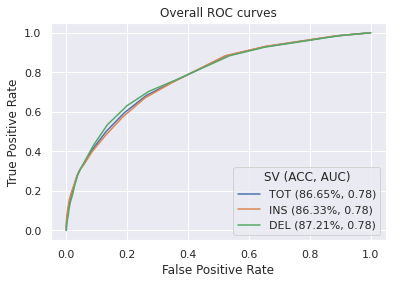

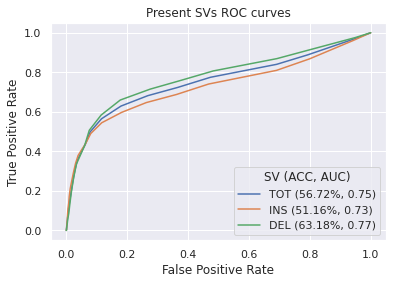

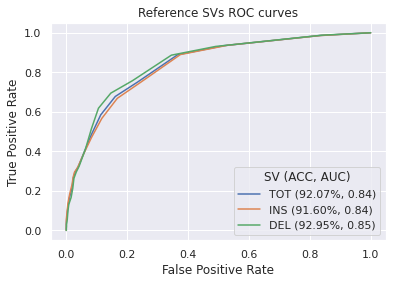

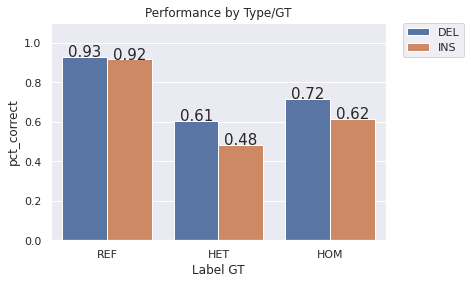

  svtype   GT  pct_correct
0    DEL  REF     0.929462
1    DEL  HET     0.606006
2    DEL  HOM     0.715229
3    INS  REF     0.916010
4    INS  HET     0.484573
5    INS  HOM     0.615105


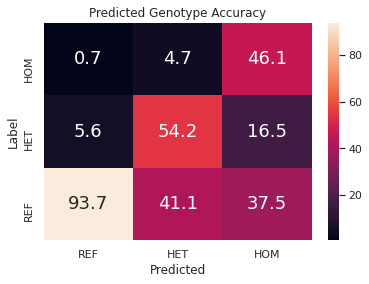

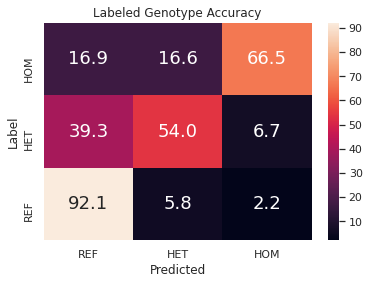

Presence Performance Overall
        TPR      FPR       FDR     ACC      TNR       PPV       NPV        F1  \
0  0.656301  0.07928  0.400297  0.8802  0.92072  0.599703  0.936718  0.626727   

        BA  
0  0.78851  


In [13]:
accuracy_report(results)

percent of sites with no neighbors: 0.23351589532498568
33811 SVs to report
Overall Accuracy: 0.9384815592558635
GT_label
0    0.961715
1    0.850528
2    0.883466
Name: concordant, dtype: float64


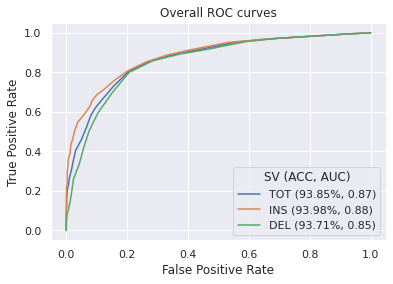

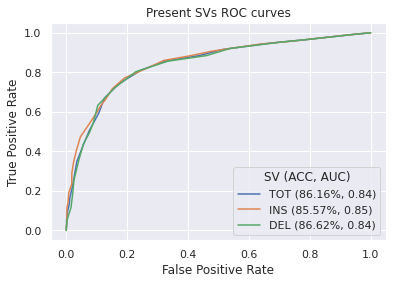

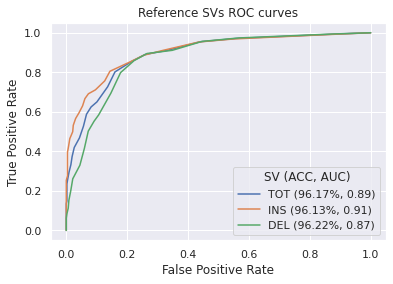

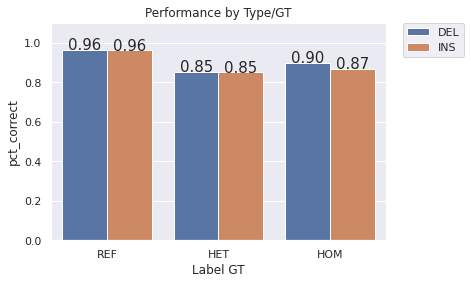

  svtype   GT  pct_correct
0    DEL  REF     0.962199
1    DEL  HET     0.851237
2    DEL  HOM     0.896575
3    INS  REF     0.961268
4    INS  HET     0.849601
5    INS  HOM     0.867287


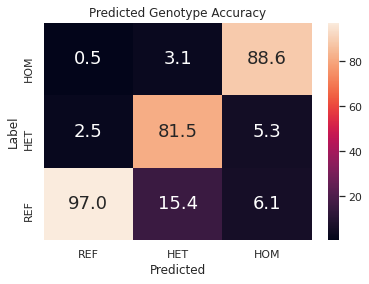

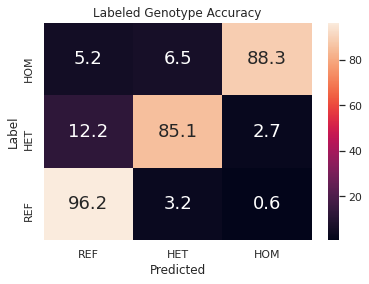

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.901376  0.038285  0.123203  0.947709  0.961715  0.876797  0.969934   

         F1        BA  
0  0.888917  0.931545  


In [14]:
no_neigh = results["NumNeighbors"] == 0
print("percent of sites with no neighbors:", len(results[no_neigh]) / len(results))
accuracy_report(results[no_neigh])

percent of sites with no_neigh and sufficent coverage: 0.20386626240581252
29518 SVs to report
Overall Accuracy: 0.9508435530862525
GT_label
0    0.969624
1    0.879153
2    0.914645
Name: concordant, dtype: float64


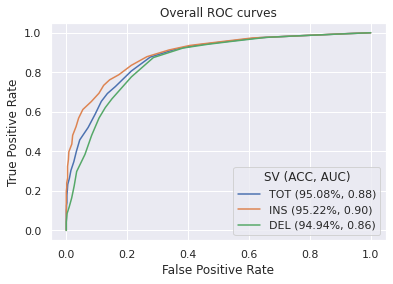

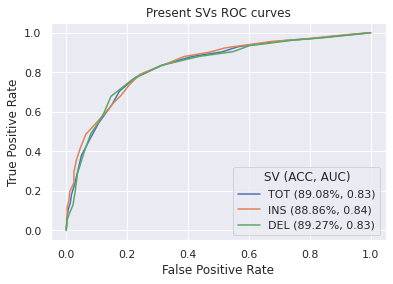

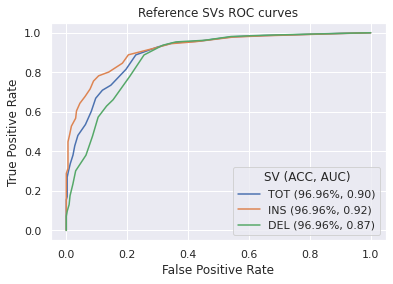

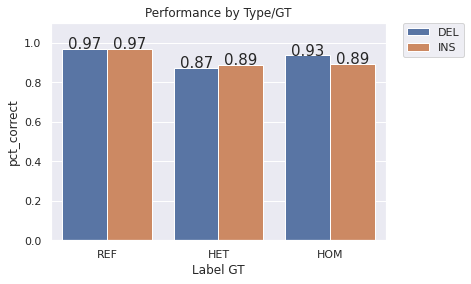

  svtype   GT  pct_correct
0    DEL  REF     0.969649
1    DEL  HET     0.873229
2    DEL  HOM     0.934946
3    INS  REF     0.969602
4    INS  HET     0.886471
5    INS  HOM     0.892696


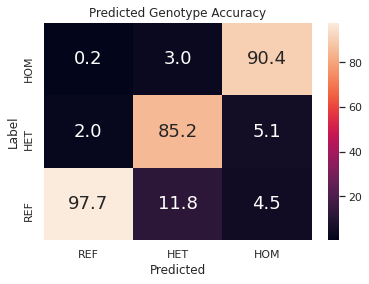

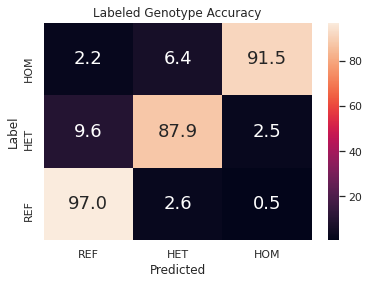

Presence Performance Overall
       TPR       FPR      FDR       ACC       TNR      PPV       NPV  \
0  0.92848  0.030376  0.09469  0.959821  0.969624  0.90531  0.977449   

         F1        BA  
0  0.916749  0.949052  


In [15]:
# Only analyze sites that have sufficient depth
has_cov = (results["DP"] >= 10) & (results["DP"] <= 100)
print("percent of sites with no_neigh and sufficent coverage:", len(results[no_neigh & has_cov]) / len(results))
accuracy_report(results[no_neigh & has_cov])

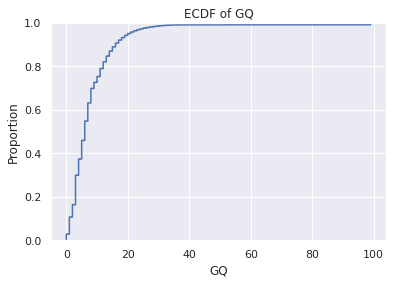

In [16]:
p = sb.ecdfplot(results["GQ"])
#plt.xticks(range(0, results["GQ"].max() + 1))
hide = p.set(title="ECDF of GQ")

percent of sites with no_neigh, sufficent coverage and high confidence 0.6262129552251176
90670 SVs to report
Overall Accuracy: 0.9440167640895555
GT_label
0    0.979951
1    0.682243
2    0.837559
Name: concordant, dtype: float64


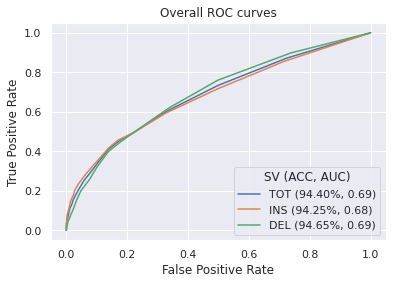

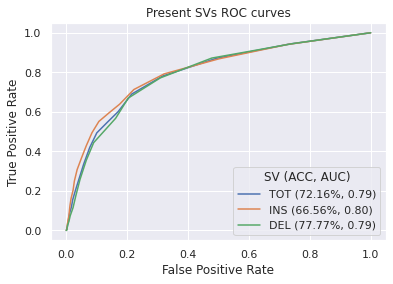

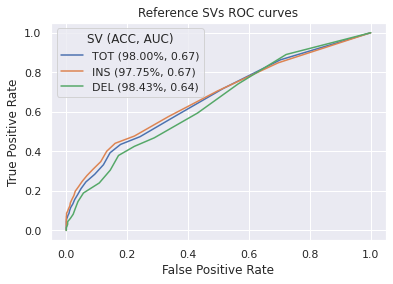

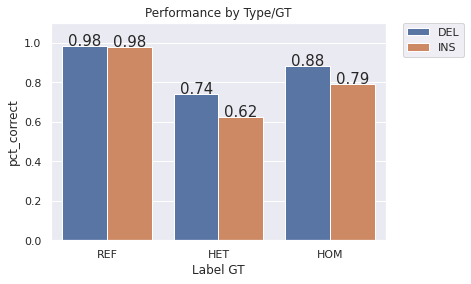

  svtype   GT  pct_correct
0    DEL  REF     0.984266
1    DEL  HET     0.740916
2    DEL  HOM     0.881675
3    INS  REF     0.977516
4    INS  HET     0.624974
5    INS  HOM     0.790562


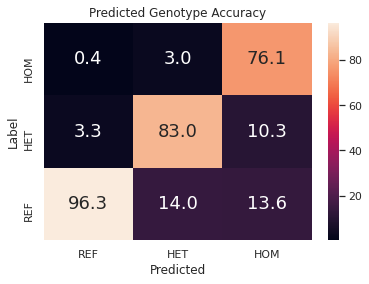

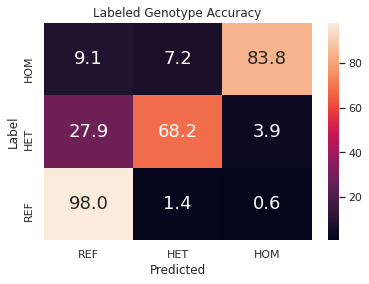

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.768535  0.020049  0.139025  0.950546  0.979951  0.860975  0.963243   

         F1        BA  
0  0.812133  0.874243  


In [17]:
# Only analyze sites that have sufficient depth and a very confident predicted genotype
high_conf = results["GQ"] >= 5
print("percent of sites with no_neigh, sufficent coverage and high confidence", len(results[high_conf]) / len(results))
accuracy_report(results[high_conf])

# Comparing against Paragraph

In [25]:
p_results, p_data = make_paragraph_results("/home/english/science/english/msru/data/paragraph_ref/HG03371.vcf.gz")

In [33]:
a = performance_table(p_results)
a["Method"] = "Paragraph"
a["Neigh"] = True
b = performance_table(p_results[p_results["NumNeighbors"] == 0])
b["Method"] = "Paragraph"
b["Neigh"] = False
full_presence = pd.concat([bg_presence, a,b])
full_presence

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA,Method,Neigh
0,0.669145,0.088489,0.422206,0.874371,0.911511,0.577794,0.938360,0.620124,0.790328,BioGraph,True
0,0.913609,0.042638,0.133744,0.947207,0.957362,0.866256,0.973447,0.889302,0.935485,BioGraph,False
0,0.896703,0.579777,0.787281,0.491084,0.420223,0.212719,0.958825,0.343866,0.658463,Paragraph,True
0,0.925368,0.124425,0.294968,0.887686,0.875575,0.705032,0.973336,0.800312,0.900472,Paragraph,False


191900 SVs to report
Overall Accuracy: 0.456284523189161
GT_label
0    0.420223
1    0.628650
2    0.778480
Name: concordant, dtype: float64


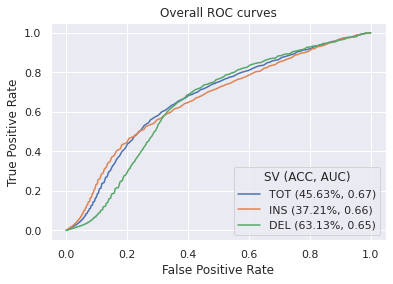

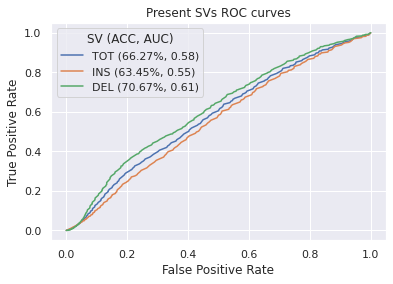

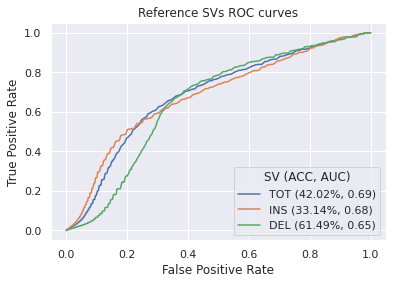

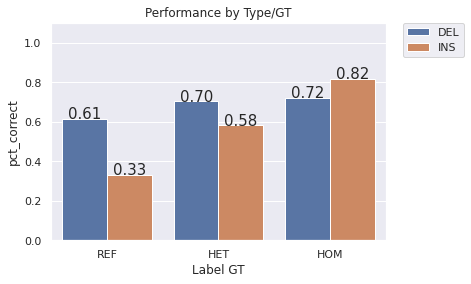

  svtype   GT  pct_correct
0    DEL  REF     0.614884
1    DEL  HET     0.702406
2    DEL  HOM     0.720867
3    INS  REF     0.331375
4    INS  HET     0.581838
5    INS  HOM     0.816598


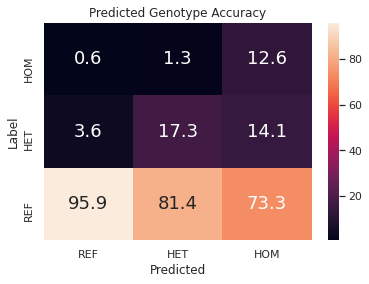

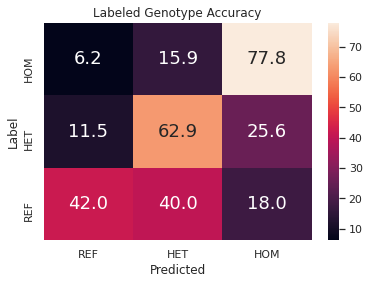

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.896703  0.579777  0.787281  0.491084  0.420223  0.212719  0.958825   

         F1        BA  
0  0.343866  0.658463  


In [34]:
accuracy_report(p_results)

38784 SVs to report
Overall Accuracy: 0.8709003712871287
GT_label
0    0.875575
1    0.825935
2    0.909889
Name: concordant, dtype: float64


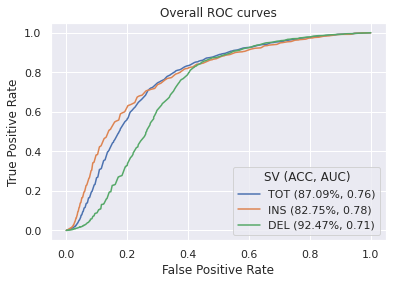

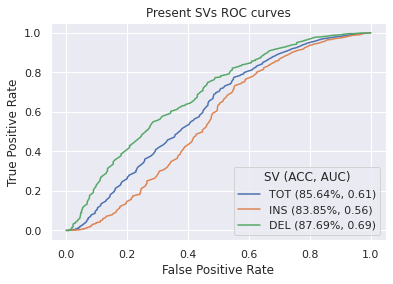

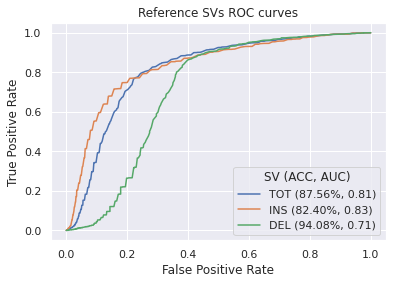

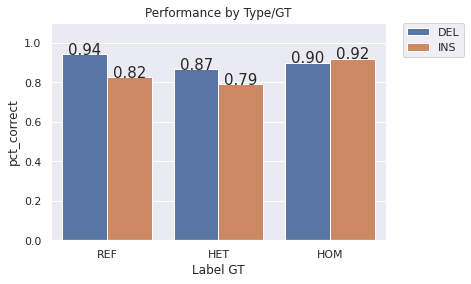

  svtype   GT  pct_correct
0    DEL  REF     0.940795
1    DEL  HET     0.865231
2    DEL  HOM     0.899333
3    INS  REF     0.824042
4    INS  HET     0.789860
5    INS  HOM     0.918144


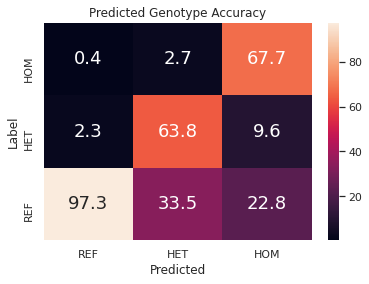

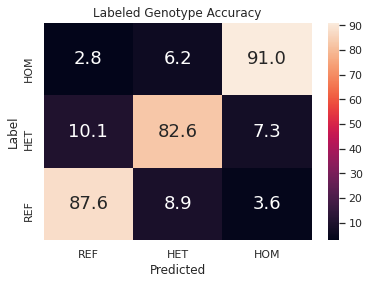

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.925368  0.124425  0.294968  0.887686  0.875575  0.705032  0.973336   

         F1        BA  
0  0.800312  0.900472  


In [35]:
p_no_neigh = p_results["NumNeighbors"] == 0
accuracy_report(p_results[p_no_neigh])

37215 SVs to report
Overall Accuracy: 0.8914953647722692
GT_label
0    0.897760
1    0.842953
2    0.928771
Name: concordant, dtype: float64


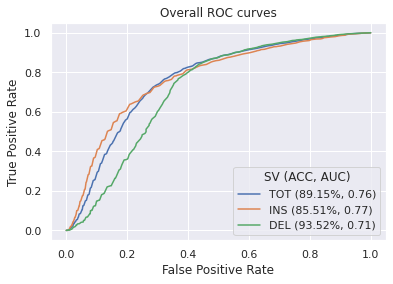

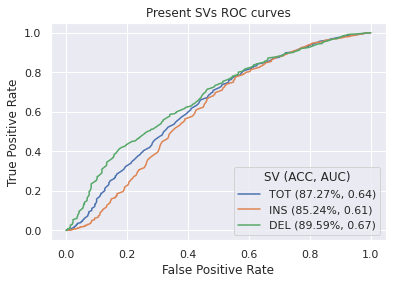

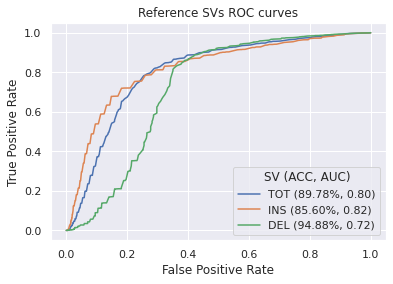

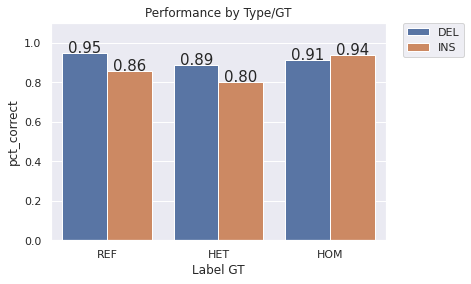

  svtype   GT  pct_correct
0    DEL  REF     0.948841
1    DEL  HET     0.887157
2    DEL  HOM     0.914286
3    INS  REF     0.856017
4    INS  HET     0.801278
5    INS  HOM     0.939858


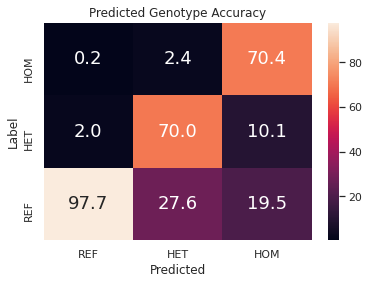

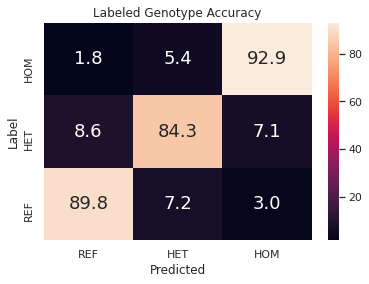

Presence Performance Overall
        TPR      FPR       FDR       ACC      TNR       PPV       NPV  \
0  0.937594  0.10224  0.246331  0.907725  0.89776  0.753669  0.977334   

         F1        BA  
0  0.835631  0.917677  


In [22]:
p_has_cov = (p_results["DP"] >= 10) & (p_results["DP"] <= 100)
accuracy_report(p_results[p_no_neigh & p_has_cov])

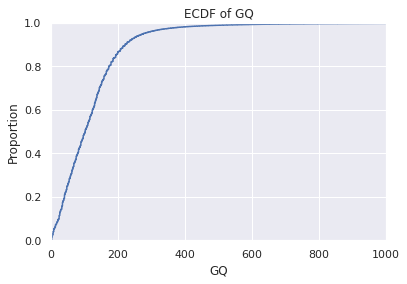

In [23]:
p = sb.ecdfplot(p_results["GQ"])
hide = p.set(title="ECDF of GQ", xlim=(0, 1000))

37215 SVs to report
Overall Accuracy: 0.8914953647722692
GT_label
0    0.897760
1    0.842953
2    0.928771
Name: concordant, dtype: float64


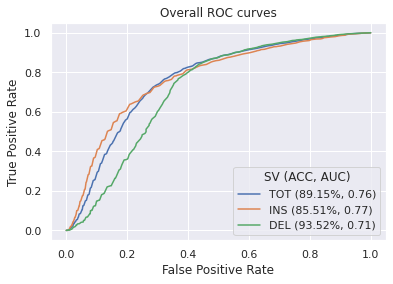

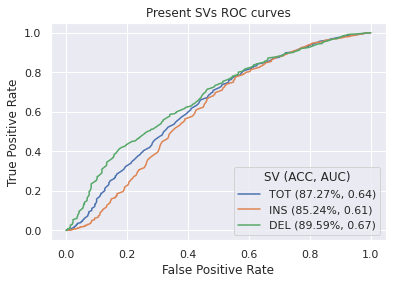

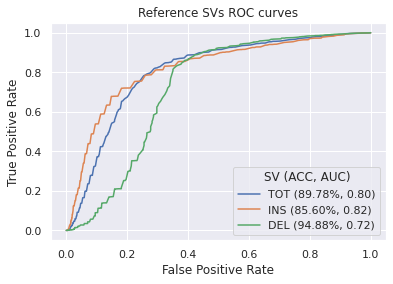

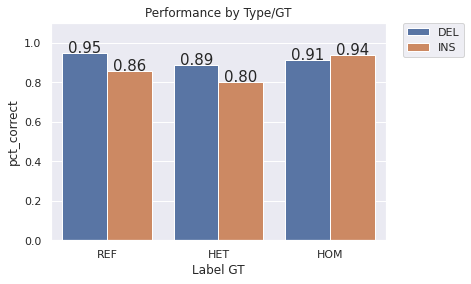

  svtype   GT  pct_correct
0    DEL  REF     0.948841
1    DEL  HET     0.887157
2    DEL  HOM     0.914286
3    INS  REF     0.856017
4    INS  HET     0.801278
5    INS  HOM     0.939858


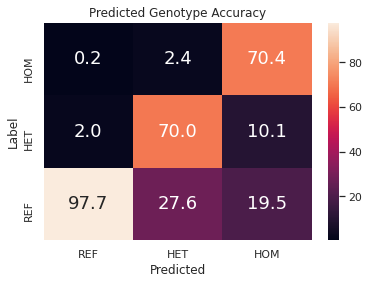

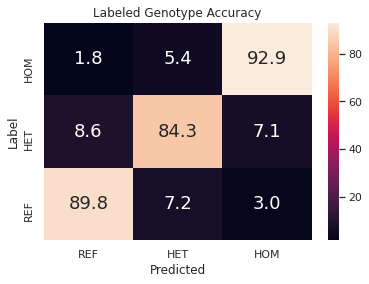

Presence Performance Overall
        TPR      FPR       FDR       ACC      TNR       PPV       NPV  \
0  0.937594  0.10224  0.246331  0.907725  0.89776  0.753669  0.977334   

         F1        BA  
0  0.835631  0.917677  


In [24]:
p_high_conf = p_results["GQ"] <= 800
accuracy_report(p_results[p_no_neigh & p_has_cov])

In [25]:
a = performance_table(p_results, "predict_class")
a["Method"] = "Paragraph"
a["Neigh"] = True
b = performance_table(p_results[p_results["NumNeighbors"] == 0], "predict_class")
b["Method"] = "Paragraph"
b["Neigh"] = False
c = performance_table(results, "predict_class")
c["Method"] = "BioGraph"
c["Neigh"] = True
d = performance_table(results[results["NumNeighbors"] == 0], "predict_class")
d["Method"] = "BioGraph"
d["Neigh"] = False
full_concord = pd.concat([c, d, a, b])
full_concord

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA,Method,Neigh
0,0.622662,0.093899,0.481756,0.866539,0.906101,0.518244,0.936718,0.565675,0.764382,BioGraph,True
0,0.897293,0.049705,0.161874,0.938482,0.950295,0.838126,0.969934,0.866701,0.923794,BioGraph,False
0,0.875645,0.597643,0.840078,0.456779,0.402357,0.159922,0.961394,0.270451,0.639001,Paragraph,True
0,0.929380,0.142881,0.340099,0.873722,0.857119,0.659901,0.976012,0.771794,0.893250,Paragraph,False


In [26]:
print("presence accuracy")
full_presence

presence accuracy


,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA,Method,Neigh
0,0.656301,0.079280,0.400297,0.880200,0.920720,0.599703,0.936718,0.626727,0.788510,BioGraph,True
0,0.901376,0.038285,0.123203,0.947709,0.961715,0.876797,0.969934,0.888917,0.931545,BioGraph,False
0,0.904895,0.580895,0.783906,0.492145,0.419105,0.216094,0.961394,0.348875,0.662000,Paragraph,True
0,0.934423,0.122758,0.285498,0.891390,0.877242,0.714502,0.976012,0.809797,0.905832,Paragraph,False


In [27]:
print("concordance accuracy")
full_concord.round(decimals=2)

concordance accuracy


,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA,Method,Neigh
0,0.62,0.09,0.48,0.87,0.91,0.52,0.94,0.57,0.76,BioGraph,True
0,0.90,0.05,0.16,0.94,0.95,0.84,0.97,0.87,0.92,BioGraph,False
0,0.88,0.60,0.84,0.46,0.40,0.16,0.96,0.27,0.64,Paragraph,True
0,0.93,0.14,0.34,0.87,0.86,0.66,0.98,0.77,0.89,Paragraph,False


100022 SVs to report
Overall Accuracy: 0.8908240187158825
GT_label
0    0.944523
1    0.613831
2    0.712761
Name: concordant, dtype: float64


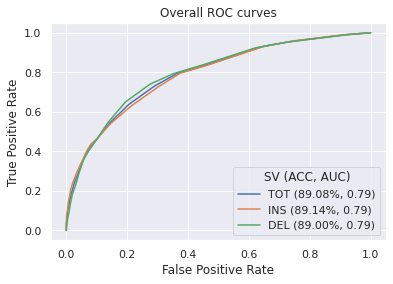

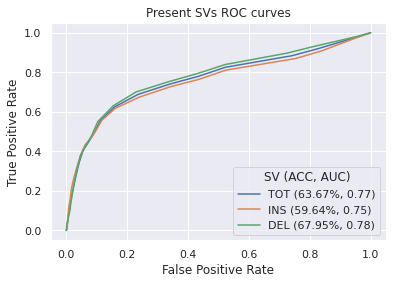

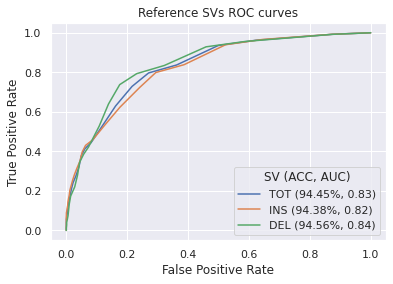

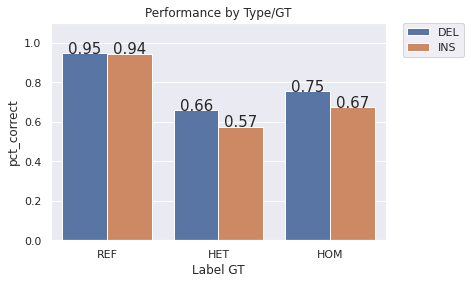

  svtype   GT  pct_correct
0    DEL  REF     0.945642
1    DEL  HET     0.656855
2    DEL  HOM     0.752882
3    INS  REF     0.943816
4    INS  HET     0.573952
5    INS  HOM     0.673389


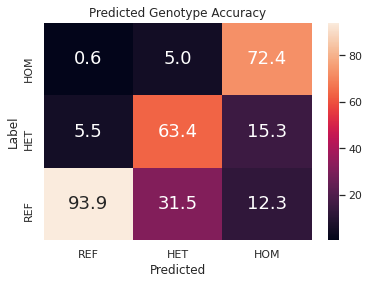

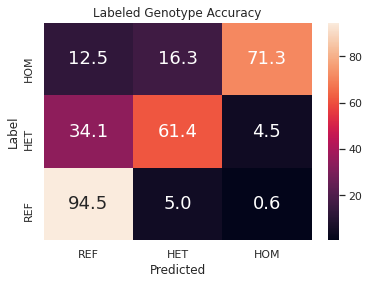

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.708947  0.055477  0.270265  0.903431  0.944523  0.729735  0.938872   

         F1        BA  
0  0.719191  0.826735  


In [28]:
accuracy_report(results[results["DP"].between(10, 100)])

33447 SVs to report
Overall Accuracy: 0.9318324513409274
GT_label
0    0.938619
1    0.879628
2    0.962963
Name: concordant, dtype: float64


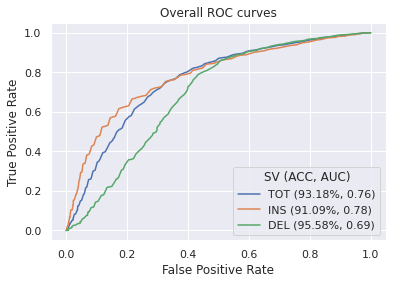

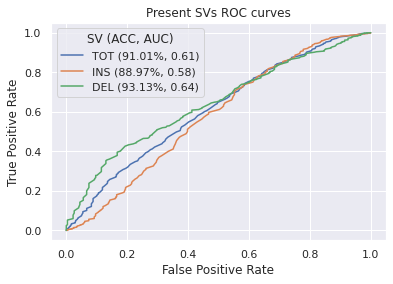

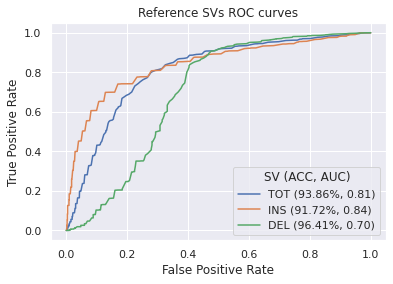

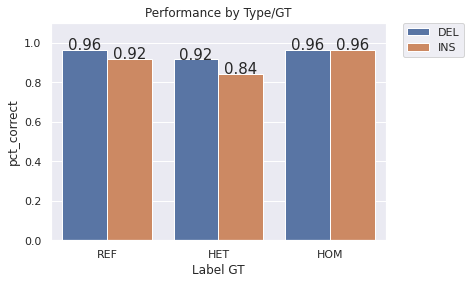

  svtype   GT  pct_correct
0    DEL  REF     0.964062
1    DEL  HET     0.915802
2    DEL  HOM     0.961977
3    INS  REF     0.917155
4    INS  HET     0.841224
5    INS  HOM     0.963773


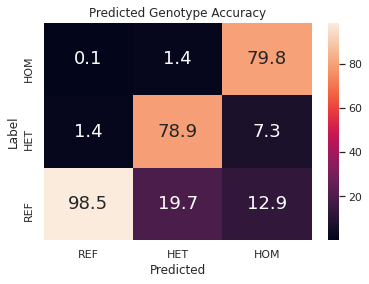

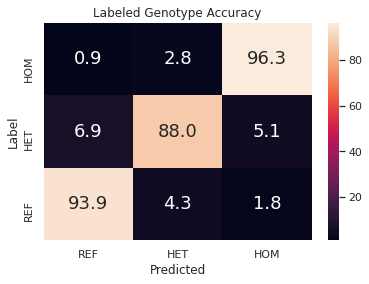

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.952805  0.061381  0.170836  0.941998  0.938619  0.829164  0.984522   

         F1        BA  
0  0.886695  0.945712  


In [29]:
accuracy_report(p_results[(p_results["NumNeighbors"] == 0) & (p_results["DP"].between(10, 100)) & p_results.index.isin(p_data[p_data["FT"] == 'PASS'].index)])

In [30]:
rows = []
for m_neigh in range(0, 10):
    for i in ["DEL", "INS"]:
        a = performance_table(p_results[(p_results["NumNeighbors"] <= m_neigh) & (p_results["svtype"] == i)], "predict_class")
        a["Method"] = "Paragraph"
        a["MaxNeigh"] = m_neigh
        a["SVTYPE"] = i
        b = performance_table(results[(results["NumNeighbors"] <= m_neigh)  & (results["svtype"] == i)], "predict_class")
        b["Method"] = "BioGraph"
        b["MaxNeigh"] = m_neigh
        b["SVTYPE"] = i
        rows.append(a)
        rows.append(b)
view = pd.concat(rows)

[Text(0.5, 1.0, 'F1 by MaxNeighbors'), (0.0, 1.0)]

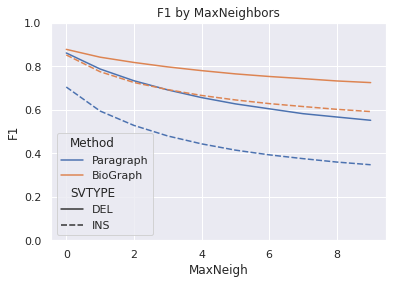

In [31]:
p = sb.lineplot(data=view, x="MaxNeigh", y="F1", hue="Method", style="SVTYPE")
p.set(title="F1 by MaxNeighbors", ylim=(0,1))

[Text(0.5, 1.0, 'Balanced Accuracy by MaxNeighbors'), (0.0, 1.0)]

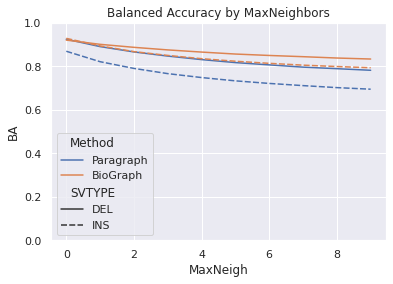

In [32]:
p = sb.lineplot(data=view, x="MaxNeigh", y="BA", hue="Method", style="SVTYPE")
p.set(title="Balanced Accuracy by MaxNeighbors", ylim=(0,1))

In [33]:
performance_table(p_results[p_results["GQ"] > 100])

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA
0,0.909706,0.427199,0.712433,0.626485,0.572801,0.287567,0.970987,0.436995,0.741253


In [34]:
q = p_results[p_results.index.isin(p_data[p_data["FT"] == "PASS"].index)]
print("keeping %.2f" % (len(p_data[p_data["FT"] == "PASS"]) / len(p_data)))
performance_table(q)

keeping 0.61


,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA
0,0.925642,0.461534,0.715297,0.60258,0.538466,0.284703,0.973326,0.435468,0.732054


In [35]:
keep = (results["DP"].between(5, 80)) & (results["GQ"] >= 2)
print("keeping %.2f" % (len(results[keep]) / len(results)))
performance_table(results[keep])

keeping 0.68


,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA
0,0.720057,0.043702,0.23848,0.917946,0.956298,0.76152,0.946312,0.740208,0.838177


In [36]:
both = results.join(p_results, how='inner', lsuffix="_bg", rsuffix="_pg")

In [37]:
both["concordant_bg"].mean(), both["concordant_pg"].mean()

(0.8665892536683205, 0.4909884232379746)

142095 SVs to report
Overall Accuracy: 0.8665892536683205
GT_label
0    0.920885
1    0.542904
2    0.665357
Name: concordant, dtype: float64


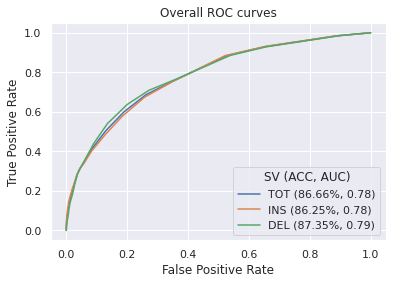

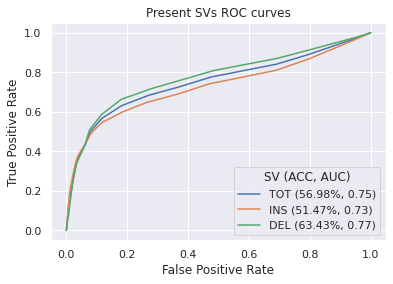

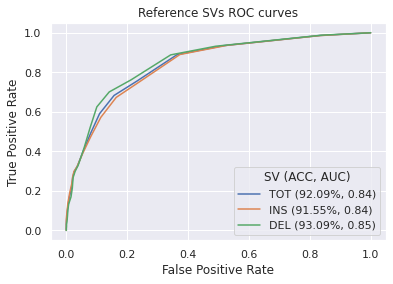

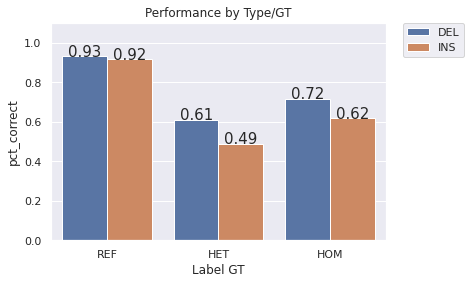

  svtype   GT  pct_correct
0    DEL  REF     0.930882
1    DEL  HET     0.609379
2    DEL  HOM     0.715852
3    INS  REF     0.915459
4    INS  HET     0.487901
5    INS  HOM     0.616728


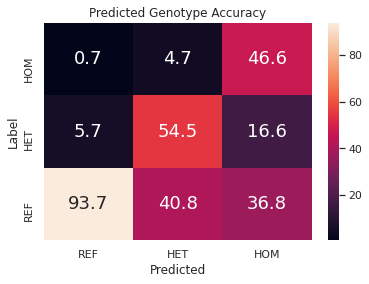

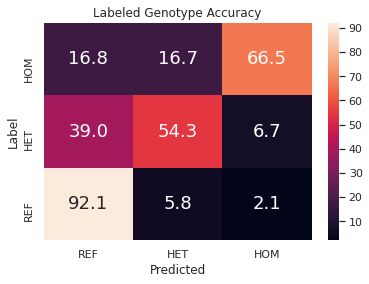

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.658886  0.079115  0.396222  0.880362  0.920885  0.603778  0.936526   

         F1        BA  
0  0.630129  0.789886  


In [38]:
accuracy_report(results[results.index.isin(both.index)])

142095 SVs to report
Overall Accuracy: 0.4909884232379746
GT_label
0    0.456061
1    0.652849
2    0.785478
Name: concordant, dtype: float64


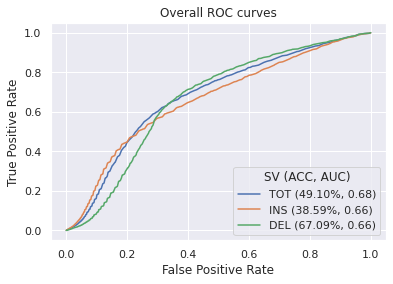

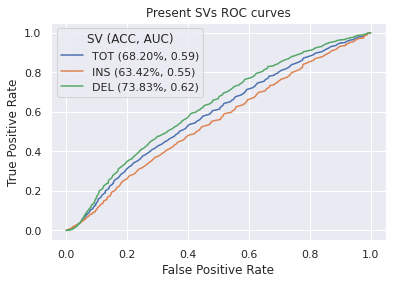

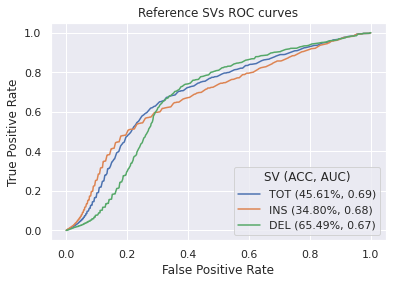

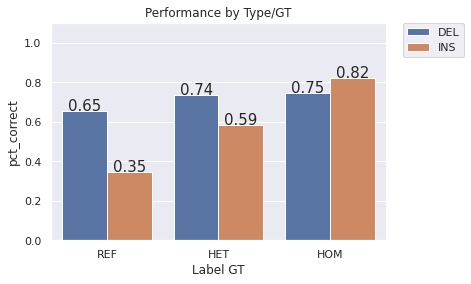

  svtype   GT  pct_correct
0    DEL  REF     0.654854
1    DEL  HET     0.735363
2    DEL  HOM     0.747683
3    INS  REF     0.348019
4    INS  HET     0.585140
5    INS  HOM     0.821951


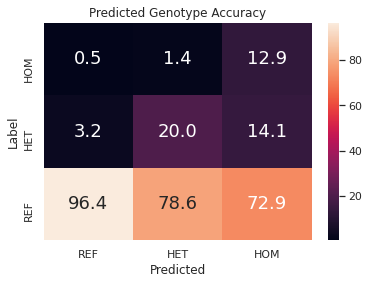

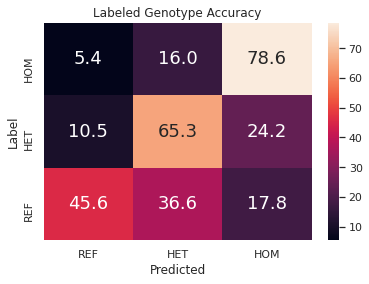

Presence Performance Overall
        TPR       FPR       FDR       ACC       TNR       PPV       NPV  \
0  0.906202  0.543939  0.766537  0.525634  0.456061  0.233463  0.963763   

         F1        BA  
0  0.371275  0.681131  


In [39]:
accuracy_report(p_results[p_results.index.isin(both.index)])

In [40]:
both_correct = both["concordant_pg"] & both["concordant_bg"]
p_correct = both["concordant_pg"] & ~both["concordant_bg"]
b_correct = ~both["concordant_pg"] & both["concordant_bg"]
neither = ~both["concordant_pg"] & ~both["concordant_bg"]

In [41]:
p  = None
frame = []
nn = both["NumNeighbors_bg"] == 0
for d, name in [(both_correct, "both"), (p_correct, "Paragraph"), (b_correct, "BioGraph"), (neither, "neither")]:
    d = d & nn
    num_svs, avg_nn = d.sum(), both[d]["NumNeighbors_bg"].mean().round(decimals=1)
    v = (both[d]["svtype_bg"].value_counts() / both[nn]["svtype_bg"].value_counts() * 100).round(decimals=1)
    pct_del = v.loc["DEL"]
    pct_ins = v.loc["INS"]
    v = (both[d]["GT_label_bg"].value_counts() / both[nn]["GT_label_bg"].value_counts() * 100).round(decimals=1)
    pct_ref = v.loc[0]
    pct_het = v.loc[1]
    pct_hom = v.loc[2]
    frame.append([name, num_svs, avg_nn, pct_del, pct_ins, pct_ref, pct_het, pct_hom])
summary = pd.DataFrame(frame, columns=["CorrectSet", "NumSVs", "muNN", "PctDel", "PctIns", "PctREF", "PctHet", "PctHom"])
summary["PctSVs"] = (summary["NumSVs"] / len(both[nn]) * 100).round(decimals=1)

In [42]:
summary

,CorrectSet,NumSVs,muNN,PctDel,PctIns,PctREF,PctHet,PctHom,PctSVs
0,both,28030,0.0,89.5,79.1,85.9,76.3,84.0,84.3
1,Paragraph,1133,0.0,3.8,3.0,2.1,8.2,7.0,3.4
2,BioGraph,3243,0.0,4.5,15.0,10.5,8.8,4.4,9.8
3,neither,846,0.0,2.2,2.9,1.5,6.6,4.5,2.5


In [43]:
summary

,CorrectSet,NumSVs,muNN,PctDel,PctIns,PctREF,PctHet,PctHom,PctSVs
0,both,28030,0.0,89.5,79.1,85.9,76.3,84.0,84.3
1,Paragraph,1133,0.0,3.8,3.0,2.1,8.2,7.0,3.4
2,BioGraph,3243,0.0,4.5,15.0,10.5,8.8,4.4,9.8
3,neither,846,0.0,2.2,2.9,1.5,6.6,4.5,2.5


In [44]:
p_data[p_data.index.isin(both[b_correct].index)]["FT"].value_counts()

PASS              29116
GQ                13719
CONFLICT          10498
BP_NO_GT           3423
BP_DEPTH           2900
(GQ, BP_DEPTH)      119
Name: FT, dtype: int64

[(0.0, 50.0)]

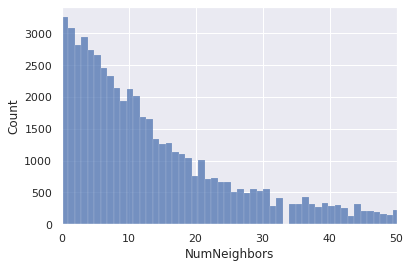

In [45]:
sb.histplot(p_data[p_data.index.isin(both[b_correct].index)]["NumNeighbors"]).set(xlim=(0,50))